In [8]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [248]:
def global_efficiency(graph):
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
    efficiency = 0
    efficiency_euclid = 0
    N = len(G.nodes)
    for i in range(N):
        for j in range(N):
            if i!=j:
                if G.has_edge(i,j):
                    d_ij = nx.shortest_path_length(G, i, j, weight='length')
                    efficiency += 1 / d_ij
                    #euclid_distance = (2*np.pi*6371000*ox.distance.euclidean(nodes['lat'][i],nodes['lon'][i],nodes['lat'][j],nodes['lon'][j]))/360
                    #efficiency_euclid += 1 / euclid_distance
                    global_efficiency = efficiency/(N*(N-1))
    return global_efficiency

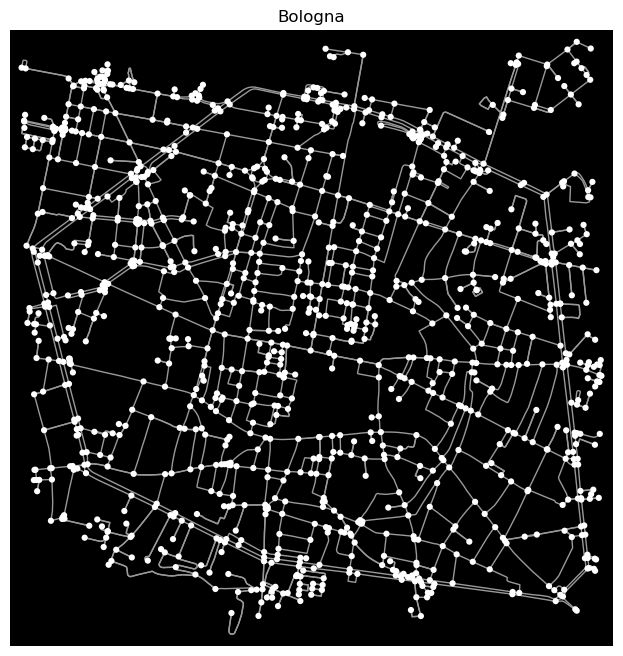

In [210]:
location_point = (44.495555, 11.3428)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=1300, dist_type='bbox', network_type='drive_service', simplify = True)
G = ox.project_graph(G)
osmids = list(G.nodes)
G = nx.relabel.convert_node_labels_to_integers(G)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(G.nodes, osmids)}
nx.set_node_attributes(G, osmid_values, "osmid")


fig, ax = ox.plot.plot_graph(G, bgcolor='black',node_size=20, node_color='white', show=False)
plt.axis('on')
plt.title('Bologna')
plt.show()


In [10]:
#connectivity analysis
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()

#meshedness coefficient
alpha = (n_edges - n_nodes + 1) / (2 * n_nodes - 5)

#connectivity
beta = n_edges/n_nodes

# gammaindex is a measure of the relation between the real number of edges and the number of all possible edges in a network
gamma = n_edges/(3*(n_nodes-2))

#characteristic path length
#l_geo = nx.average_shortest_path_length(G)

#print results
print(n_edges)
print(n_nodes)
print("meshedness coefficient:", alpha)
print("beta connectivity:", beta)
print("gamma index", gamma)
#print("characteristic path length:", l_geo)


2113
1166
meshedness coefficient: 0.4073914911903739
beta connectivity: 1.8121783876500857
gamma index 0.6050973654066437


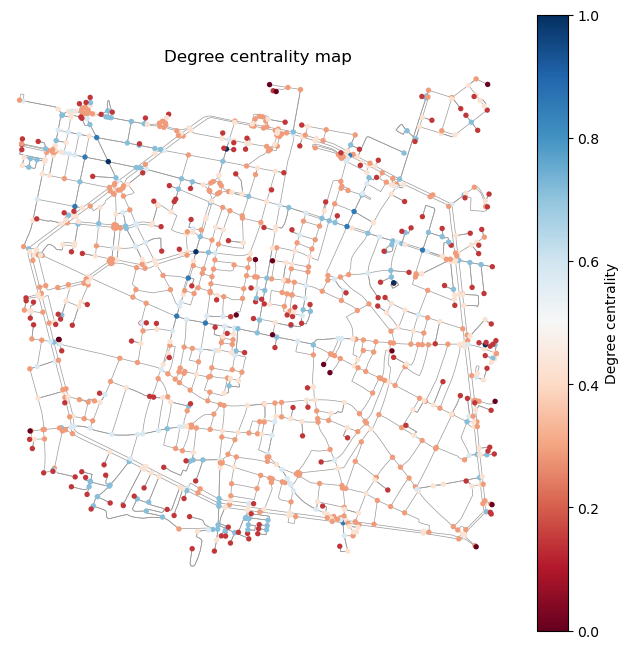

In [11]:
# compute degree centrality
degree_centrality = nx.degree_centrality(G)

dc_values = np.array([degree_centrality[node] for node in G.nodes])

# normalize 
norm_dc_values = (dc_values - min(dc_values)) / (max(dc_values) - min(dc_values))

# Plot the graph with a heatmap based on degree centrality
cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_dc_values.min(), vmax=norm_dc_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, 
                        node_color=plt.cm.RdBu(norm_dc_values), 
                        node_size=15, 
                        edge_linewidth=0.5, 
                        bgcolor = 'white', 
                        show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Degree centrality')
plt.axis('on')
plt.title('Degree centrality map')
plt.show()

Text(0, 0.5, '# of Nodes')

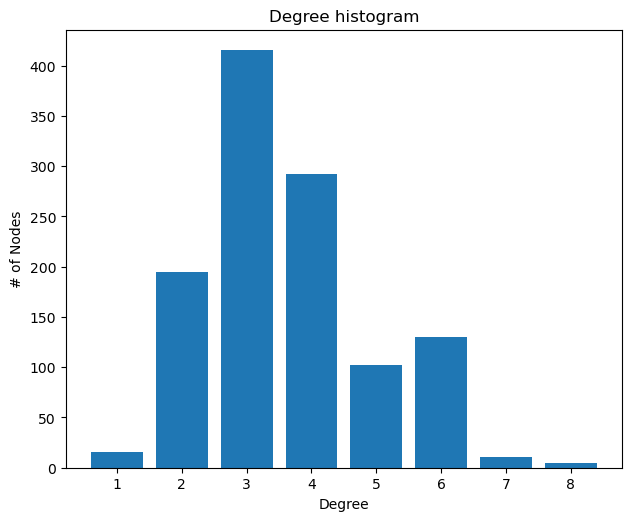

In [29]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(15, 15))

axgrid = fig.add_gridspec(5, 4)



ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

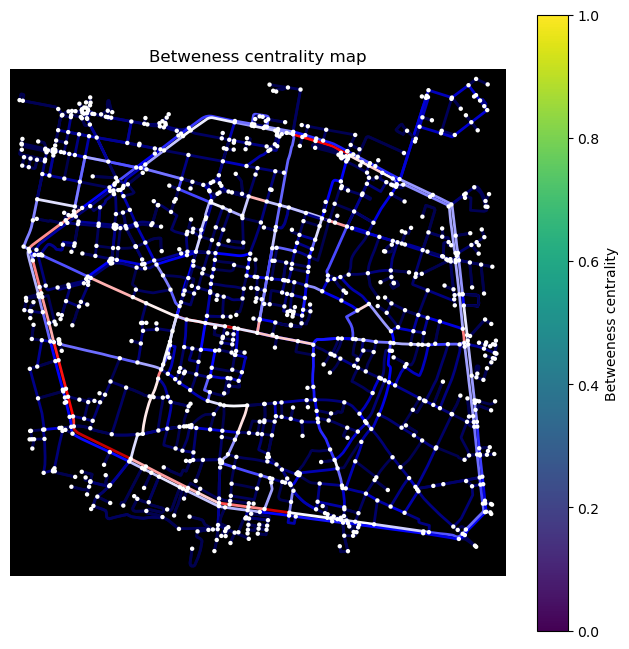

In [12]:
# compute betweness centrality
edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

ebc_values = np.array([edge_betweenness_centrality[edge] for edge in G.edges])

#normalize
norm_ebc_values = (ebc_values - min(ebc_values)) / (max(ebc_values) - min(ebc_values))

# Plot
fig, ax = ox.plot_graph(
    G,
    bgcolor='black',
    node_size=10,
    edge_color=plt.cm.seismic(norm_ebc_values),  
    edge_linewidth=2, 
    show=False
)

# Color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, label='Betweeness centrality')

plt.axis('on')
plt.title('Betweness centrality map')
plt.show()

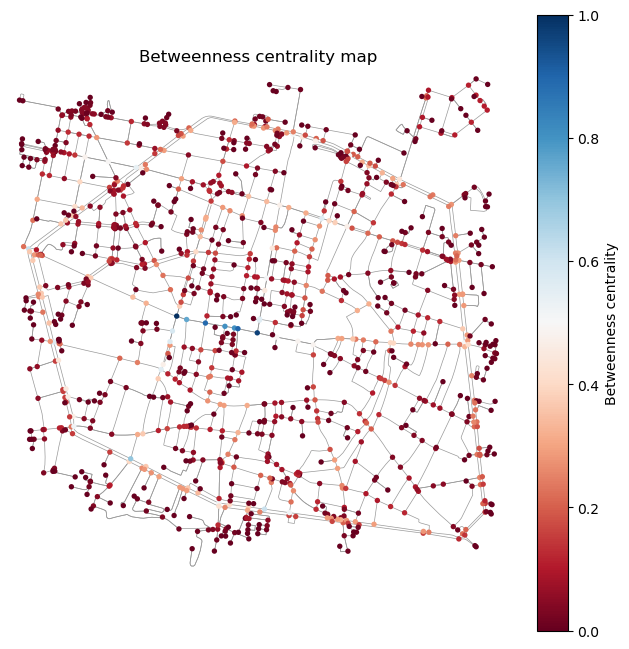

In [14]:
# compute betweness centrality
betweenness_centrality = nx.betweenness_centrality(G)

ebc_values = np.array([betweenness_centrality[node] for node in G.nodes])

#normalize
norm_ebc_values = (ebc_values - min(ebc_values)) / (max(ebc_values) - min(ebc_values))


cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_ebc_values.min(), vmax=norm_ebc_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, node_color=plt.cm.RdBu(norm_ebc_values), node_size=15, edge_linewidth=0.5, bgcolor = 'white', show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Betweenness centrality')
plt.axis('on')
plt.title('Betweenness centrality map')
plt.show()

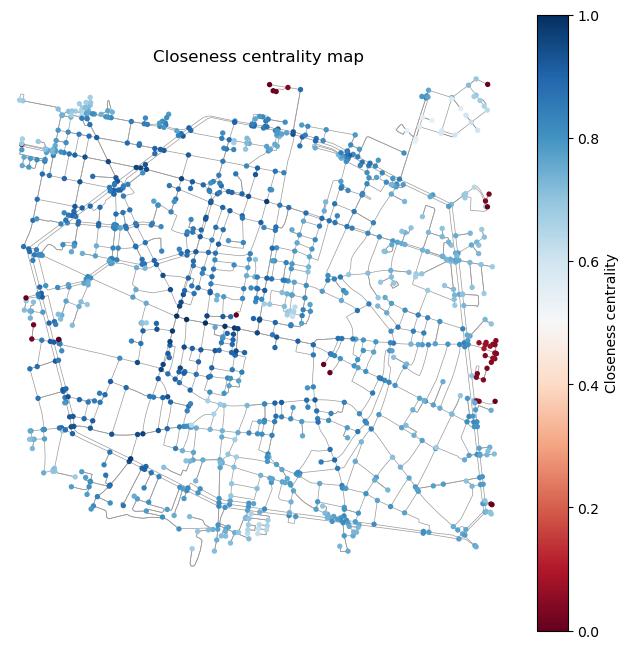

In [15]:
# compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

c_values = np.array([closeness_centrality[node] for node in G.nodes])

#normalize
norm_c_values = (c_values - min(c_values)) / (max(c_values) - min(c_values))


cmap = 'RdBu'
norm=plt.Normalize(vmin=norm_c_values.min(), vmax=norm_c_values.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, node_color=plt.cm.RdBu(norm_c_values), node_size=15, edge_linewidth=0.5, bgcolor = 'white', show=False)

cb = fig.colorbar(sm, ax=ax, label = 'Closeness centrality')
plt.axis('on')
plt.title('Closeness centrality map')
plt.show()

In [250]:
#computing Global Efficiency
G1 = global_efficiency(G)

#computing Information Centrality
G.remove_edge(4,7) #remove some edges wiht for loops
G2 = global_efficiency(G) #ma perchè scriviamo in inglese?
print(G1,G2, G1-G2, (G1-G2)/G1) #scemo chi legge
G.edges #scemo chi l'edges

5.343154490489026e-05 5.341842438039934e-05 1.3120524490921922e-08 0.00024555764790774523


OutMultiEdgeView([(2, 0, 0), (4, 8, 0), (5, 4, 0), (5, 202, 0), (6, 322, 0), (6, 448, 0), (6, 4, 0), (7, 5, 0), (7, 305, 0), (8, 448, 0), (9, 10, 0), (9, 11, 0), (10, 449, 0), (11, 323, 0), (11, 324, 0), (12, 13, 0), (13, 746, 0), (13, 14, 0), (14, 15, 0), (14, 16, 0), (15, 289, 0), (15, 17, 0), (16, 641, 0), (16, 365, 0), (17, 18, 0), (18, 586, 0), (18, 124, 0), (19, 20, 0), (20, 289, 0), (20, 125, 0), (21, 22, 0), (21, 23, 0), (22, 21, 0), (23, 508, 0), (23, 608, 0), (23, 21, 0), (24, 25, 0), (24, 26, 0), (25, 296, 0), (26, 275, 0), (26, 27, 0), (27, 28, 0), (27, 29, 0), (28, 442, 0), (29, 445, 0), (29, 446, 0), (30, 31, 0), (30, 32, 0), (31, 133, 0), (31, 134, 0), (31, 135, 0), (32, 396, 0), (33, 34, 0), (33, 35, 0), (33, 36, 0), (34, 661, 0), (34, 1027, 0), (34, 33, 0), (35, 108, 0), (36, 110, 0), (36, 33, 0), (37, 38, 0), (37, 39, 0), (37, 40, 0), (38, 37, 0), (38, 197, 0), (38, 195, 0), (39, 216, 0), (40, 80, 0), (40, 823, 0), (41, 51, 0), (42, 43, 0), (43, 42, 0), (43, 687, 0), 